# pdata with QCoDeS example

This notebook shows how to use QCoDeS for instrument control but save data using procedural_data and use standard Python flow control.

The example also shows how to read the saved data back using analysis.dataview.

Changes to instrument settings between calls to add_points() are stored automatically.

The top-level Jupyter notebook (if any) will also be saved automatically in the data directory.

In [1]:
%matplotlib notebook

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import os
import sys
import logging
import time

In [2]:
import qcodes as qc # <-- Assumes you've installed QCoDeS: https://qcodes.github.io/Qcodes/start/index.html

In [3]:
from pdata.procedural_data import run_measurement

# Define data storage location

In [4]:
data_root = r'example_data_root' # <-- path to your data root directory

# Create an artificial instrument driver for this example

In [5]:
class FakeVNA(qc.instrument.base.Instrument):

  def __init__(self, name, **kwargs):
    super().__init__(name, **kwargs)
    self._power=0
    self.add_parameter('power',  get_cmd=lambda: self._power, set_cmd=self._setp)

  def _setp(self, val):
    self._power=val

  def acquire_S21(self):
    time.sleep(0.5)
    freqs = np.linspace(5.9e9, 6.1e9, 41)
    lorenzian = lambda f,gamma,f0=6e9: 1/np.pi * (gamma**2 / ((f-f0)**2 + gamma**2))
    return freqs, lorenzian(freqs, 10e6 * 2**(self.power()/10.)) * (1 + 0.3*np.random.rand(len(freqs)))

# Init instrument and create a QCoDeS station containing one instrument

In [6]:
vna = FakeVNA(name='vna')
station = qc.Station(vna)

# Measure

In [7]:
# Define a function that gets the current instrument settings from QCoDeS (as a dict)
import qcodes.station
get_qcodes_instrument_snapshot = lambda s=qcodes.station.Station.default: s.snapshot(update=True)

In [8]:
# Columns are specified as (<name>, <unit>), or just <name> if the quantity is dimensionless.
with run_measurement(get_qcodes_instrument_snapshot,
                     columns = [("frequency", "Hz"),
                                "S21"],
                     name='power-sweep', data_base_dir=data_root) as m:

  logging.warning('This test warning will (also) end up in log.txt within the data dir.')

  data_path = m.path()
  logging.warning(f'Data directory path = {m.path()}.')

  for p in [-30, -20, -10]:
    vna.power(p)  # <-- note that this new value gets automatically stored in the data
    freqs, s21 = vna.acquire_S21()
    m.add_points({'frequency': freqs, 'S21': s21})

<IPython.core.display.Javascript object>

# Read the data back using DataView

You should almost always **have analysis in a separate Jupyter notebook**. Here it's in the same one just to keep the demo in one place.

In [9]:
from pdata.analysis.dataview import DataView, PDataSingle

In [10]:
d = DataView([ PDataSingle(data_path), ]) # <-- You can concatenate multiple data dirs by adding multiple PDataSingle's to the array

print('Instruments in the snapshot file:')
print(d.settings()[0][1]['instruments'].keys())

# Add a "column" to the data table based on a value from the snapshot.
d.add_virtual_dimension('VNA power',
                        from_set=('instruments', 'vna',
                                  'parameters', 'power', 'value'))

# You can now access the columns by name:
print('\nFirst few frequencies: %s' % (d["frequency"][:5]))
print('First few powers: %s' % (d["VNA power"][:5]))

print('\nUnique powers in the data set: %s' % (np.unique(d["VNA power"])))

print('\nSweeps based on a per-sweep-fixed parameter: %s' % d.divide_into_sweeps('VNA power'))

print('\nSweeps based on a per-sweep-swept parameter: %s' % d.divide_into_sweeps('frequency'))

Instruments in the snapshot file:
dict_keys(['vna'])

First few frequencies: [5.900e+09 5.905e+09 5.910e+09 5.915e+09 5.920e+09]
First few powers: [-30. -30. -30. -30. -30.]

Unique powers in the data set: [-30. -20. -10.]

Sweeps based on a per-sweep-fixed parameter: [slice(0, 41, None), slice(41, 82, None), slice(82, 123, None)]

Sweeps based on a per-sweep-swept parameter: [slice(0, 41, None), slice(41, 82, None), slice(82, 123, None)]


## Looking at the data as arrays

In [11]:
# Print some stored tabular data values:
d["frequency"][0::10]

array([5.900e+09, 5.950e+09, 6.000e+09, 6.050e+09, 6.100e+09, 5.945e+09,
       5.995e+09, 6.045e+09, 6.095e+09, 5.940e+09, 5.990e+09, 6.040e+09,
       6.090e+09])

In [12]:
# Print some stored tabular data values:
d["S21"][0::10]

array([5.60935117e-05, 2.24698981e-04, 3.34748598e-01, 2.11807877e-04,
       6.07028013e-05, 6.83339401e-04, 7.39845498e-02, 1.12212128e-03,
       2.25818137e-04, 2.68790131e-03, 8.04958461e-02, 6.32839873e-03,
       1.00148068e-03])

In [13]:
# Above we defined VNA power as a "virtual column", so you can access that just the same as the real tabular data columns:
d["VNA power"][0::10]

array([-30., -30., -30., -30., -30., -20., -20., -20., -20., -10., -10.,
       -10., -10.])

## Plot the sweeps

<IPython.core.display.Javascript object>


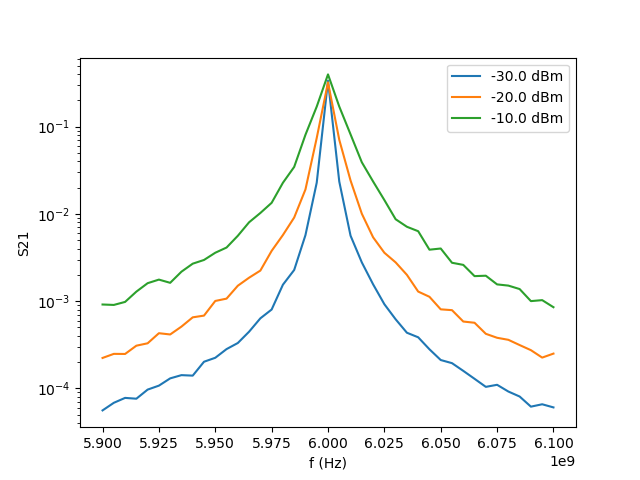

In [14]:
fig, ax = plt.subplots()

for s in d.divide_into_sweeps('frequency'):
#for s in d.divide_into_sweeps('VNA power'):  # <-- This would work equally well.
  dd = d.copy(); dd.mask_rows(s, unmask_instead=True)
  power = dd.single_valued_parameter('VNA power')
  ax.plot(dd['frequency'], dd['S21'], label="%s dBm" % power)

ax.set(xlabel=f'f (Hz)', ylabel='S21')
ax.set_yscale('log')
ax.legend();

## Dataexplorer demo: Create a similar plot using dataexplorer to quickly examine sanity of data

In [15]:
from pdata.analysis import dataexplorer

In [16]:
# Create a graphical selector for choosing one or more data sets to plot (in the next cell)
sel = dataexplorer.data_selector(data_root)
display(sel)

SelectMultiple(description='data set', index=(0,), layout=Layout(width='90%'), options=('2022-03-20_15-50-39_5…

Plotting datasets: ('2022-03-20_15-50-39_553_power-sweep',)


<IPython.core.display.Javascript object>


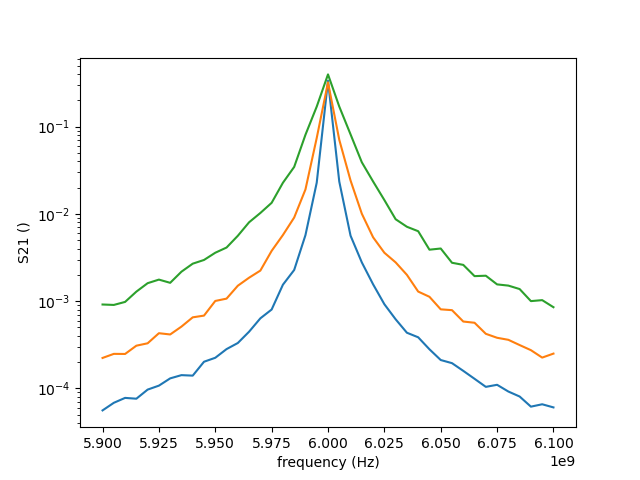

In [17]:
print(f"Plotting datasets: {sel.value}")
dataexplorer.basic_plot(data_root, sel.value, "frequency", "S21", ylog=True)